### __Model Building__

#### __Preparing data__

In [82]:
import pandas as pd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
import datetime

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

In [83]:
matplotlib.rcParams['figure.figsize'] = (25, 15)
matplotlib.rcParams['font.size'] = 10
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [84]:
property_df = pd.read_csv(r"C:/Users/payoj.jain/Documents/projects/Europe Revenue estimation/data/X_data.csv")

In [85]:
property_df.head()

,Unnamed: 0,ACCOMMODATION_CODE,ACCOMMODATION_TYPE,ACCO_DESCRIPTION,NUMBER_OF_PERSONS,BEDROOM_COUNT,BATHROOM_COUNT,HAS_WIFI,HAS_POOL,HAS_PRIVATE_POOL,HAS_SHARED_POOL,HAS_INDOOR_POOL,HAS_OUTDOOR_POOL,IS_DETACHED,HAS_SAUNA,HAS_JACUZZI,IS_SKIING,IS_ON_A_FARM,X2017.x,X2018.x,X2019.x,X2017.y,X2018.y,X2019.y,total2019,total2018,total2017,Total_HO,Total_BV,LATITUDE,LONGITUDE,max,ELEVATION,if_near_coast,distance_from_coast,nearest_coastal_longitude,nearest_coastal_latitude,COUNTRY,price,bookings_count
0,0,AT-1050-01,1,Apartment,4,1,1,1,0,0,0,0,0,0,0,0,0,0,1068.4800,0.0,0.0,2627.118,432.358,0.0,0.0,432.358,3695.5980,3059.476,1068.4800,48.184128,16.367247,3695.5980,207.0,0,NaN,NaN,NaN,AT,0.0,1.0
1,1,AT-1115-01,3,Chalet,10,0,0,0,0,0,0,0,0,1,0,0,0,0,4474.4400,0.0,0.0,0.000,0.000,0.0,0.0,0.000,4474.4400,0.000,4474.4400,47.038075,10.610737,4474.4400,1444.0,0,NaN,NaN,NaN,AT,NaN,NaN
2,2,AT-1160-01,1,Apartment,2,2,1,1,0,0,0,0,0,0,0,0,0,0,358.3000,0.0,0.0,329.472,0.000,0.0,0.0,0.000,687.7720,329.472,358.3000,48.216322,16.312146,687.7720,232.0,0,NaN,NaN,NaN,AT,NaN,NaN
3,3,AT-1160-02,1,Apartment,2,1,1,1,0,0,0,0,0,0,0,0,0,0,518.9500,0.0,0.0,123.266,0.000,0.0,0.0,0.000,642.2160,123.266,518.9500,48.216322,16.312146,642.2160,232.0,0,NaN,NaN,NaN,AT,NaN,NaN
4,4,AT-1160-03,1,Apartment,4,3,1,1,0,0,0,0,0,0,0,0,0,0,2202.5825,0.0,0.0,430.144,0.000,0.0,0.0,0.000,2632.7265,430.144,2202.5825,48.216320,16.312150,2632.7265,232.0,0,NaN,NaN,NaN,AT,NaN,NaN


In [86]:
# Clipping outliers
def clipping_outliers(X_train, df, var):
    IQR = X_train[var].quantile(0.80)-X_train[var].quantile(0.2)
    lower_bound = X_train[var].quantile(0.25) - 4*IQR
    upper_bound = X_train[var].quantile(0.75) + 4*IQR
    no_outliers = len(df[df[var]>upper_bound]) + len(df[df[var]<lower_bound])
    print('There are %i outliers in %s: %.3f%%' %(no_outliers, var, no_outliers/len(df)))
    df[var] = df[var].clip(lower_bound, upper_bound)
    return df

In [87]:
property_df[(property_df["max"] == 0) & (property_df["COUNTRY"] == "DE") & (property_df["if_near_coast"] == 1)].count()["ACCOMMODATION_CODE"]

0

In [88]:
columns = ["ACCOMMODATION_CODE","ACCOMMODATION_TYPE", "NUMBER_OF_PERSONS", "BEDROOM_COUNT", "BATHROOM_COUNT", "HAS_WIFI", "HAS_POOL","HAS_PRIVATE_POOL", "HAS_SHARED_POOL", "IS_SKIING","total2019" ,"ELEVATION", "distance_from_coast"]
# columns = ["NUMBER_OF_PERSONS", "BEDROOM_COUNT", "BATHROOM_COUNT", "HAS_WIFI", "HAS_POOL","HAS_PRIVATE_POOL", "IS_SKIING","max" ,"ELEVATION", "if_near_coast", "distance_from_coast", "price", "bookings_count"]

country_df = property_df[(property_df['COUNTRY'] == "DE") & (property_df["if_near_coast"] == 1) & (property_df["total2019"] != 0)]
data_train = country_df[columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019E1F596DC8>,
      dtype=object)

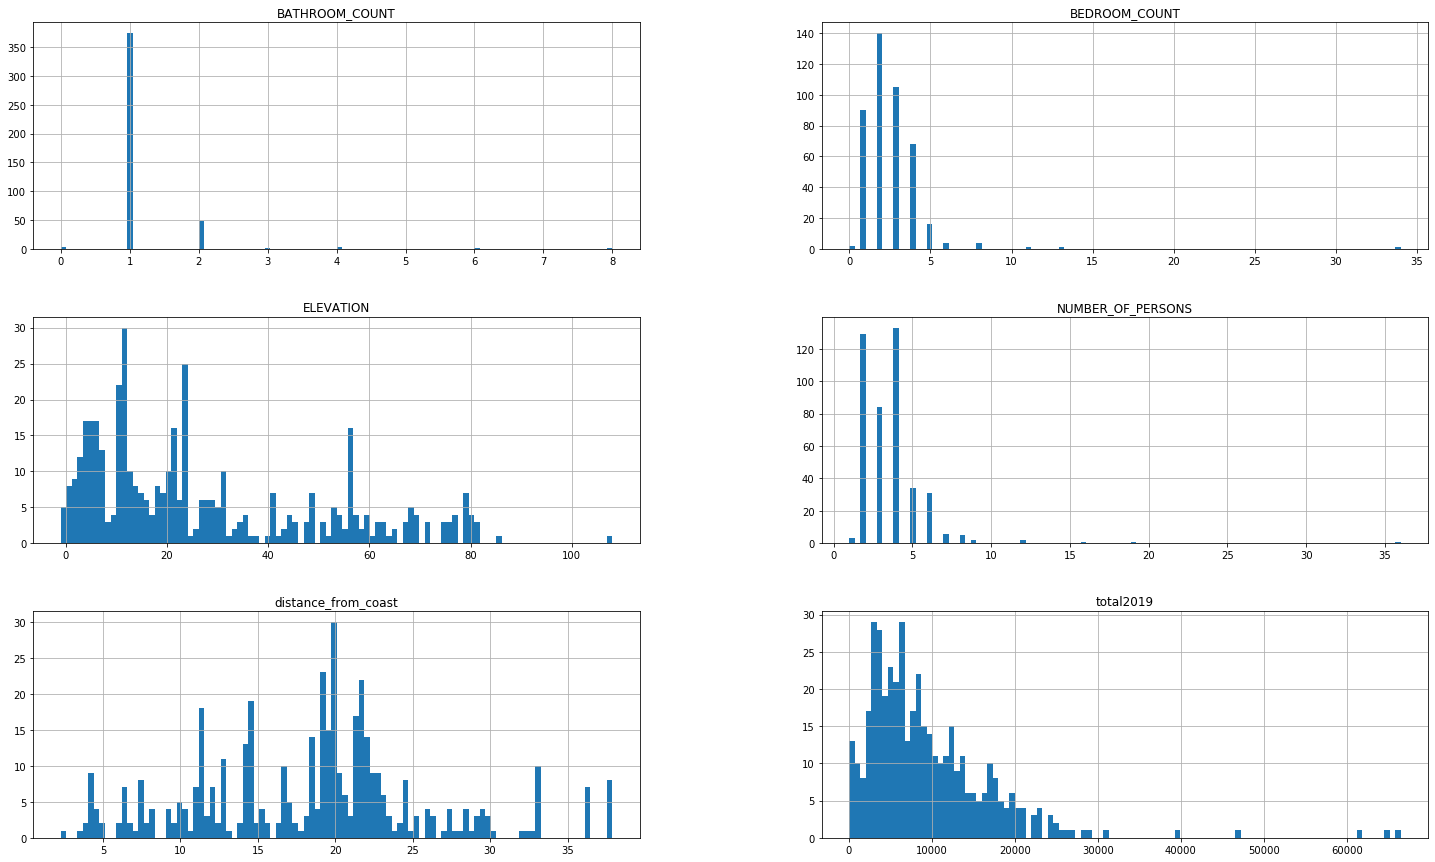

In [89]:
data_train[data_train["ACCOMMODATION_TYPE"]==1][["BATHROOM_COUNT", "BEDROOM_COUNT", "ELEVATION", "NUMBER_OF_PERSONS", "distance_from_coast", "total2019"]].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019E1F11FD88>,
      dtype=object)

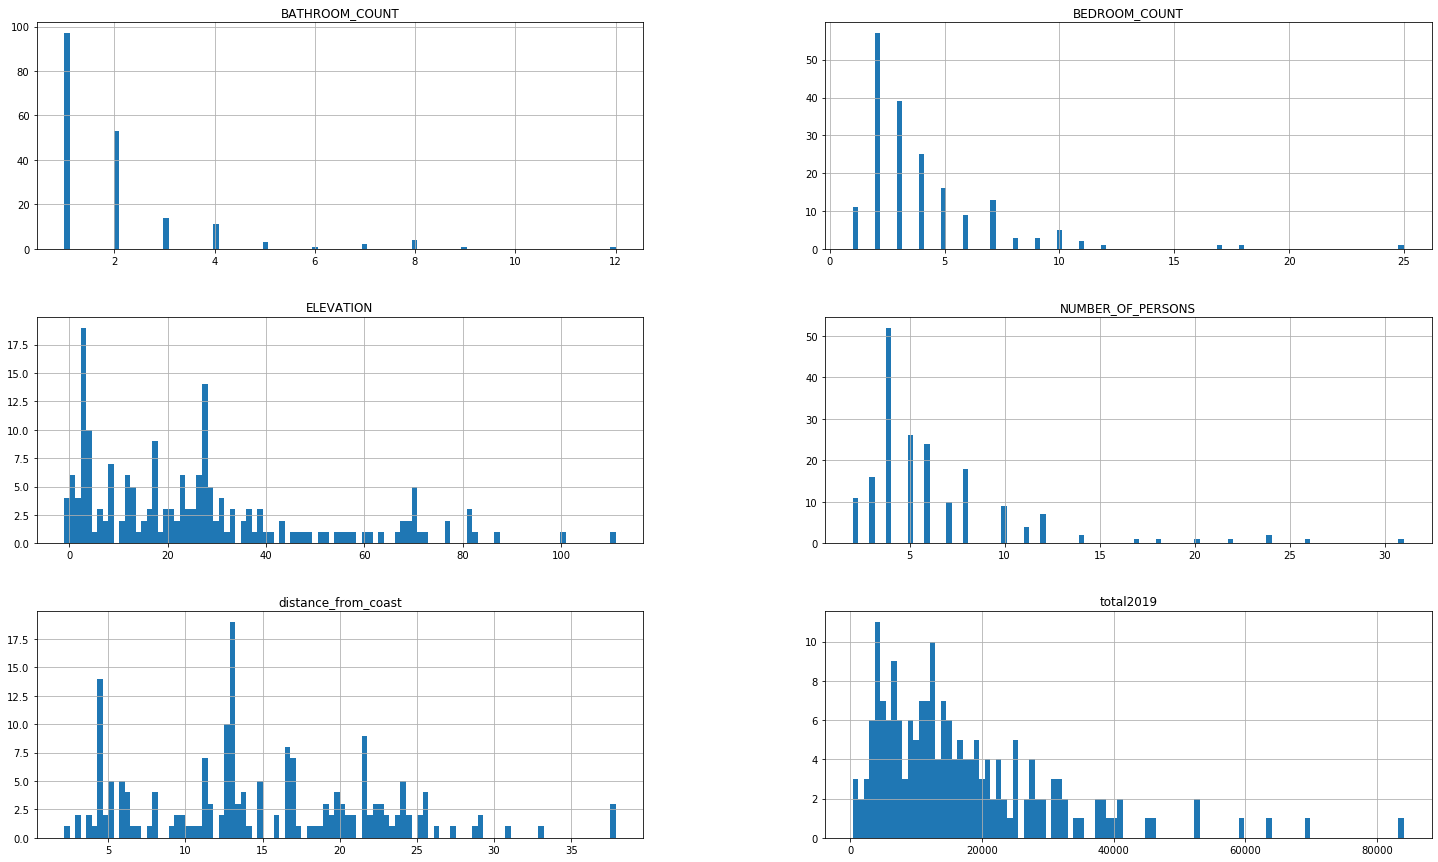

In [90]:
data_train[data_train["ACCOMMODATION_TYPE"]==2][["BATHROOM_COUNT", "BEDROOM_COUNT", "ELEVATION", "NUMBER_OF_PERSONS", "distance_from_coast", "total2019"]].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019E21AF28C8>,
      dtype=object)

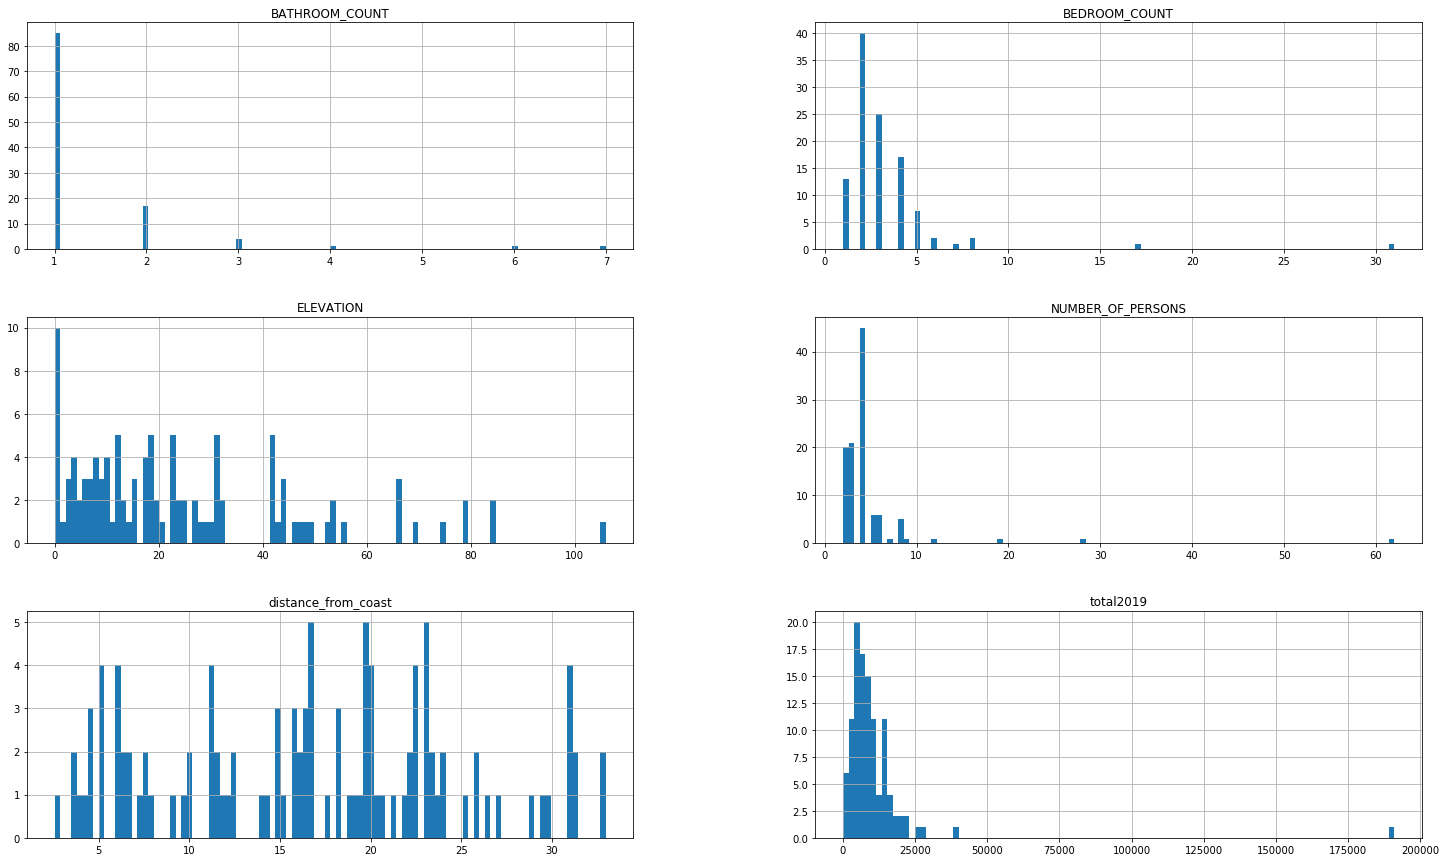

In [91]:
data_train[data_train["ACCOMMODATION_TYPE"]==3][["BATHROOM_COUNT", "BEDROOM_COUNT", "ELEVATION", "NUMBER_OF_PERSONS", "distance_from_coast", "total2019"]].hist(bins=100)

In [92]:
# data_train['price'] = data_train['price'].fillna(0)
# data_train["bookings_count"] = data_train["bookings_count"].fillna(0)
# data_train["distance_from_coast"] = data_train["distance_from_coast"].fillna(1000)
# data_train['total2018'] = data_train['total2018'].fillna(0)
# data_train = pd.get_dummies(data_train, columns=["ACCO_DESCRIPTION"], prefix=["ACCO_DESCRIPTION"])

In [93]:
for col in ["total2019"]:
    data_train = clipping_outliers(data_train, data_train, col)

There are 4 outliers in total2019: 0.005%


In [94]:
data_train.tail(4)

,ACCOMMODATION_CODE,ACCOMMODATION_TYPE,NUMBER_OF_PERSONS,BEDROOM_COUNT,BATHROOM_COUNT,HAS_WIFI,HAS_POOL,HAS_PRIVATE_POOL,HAS_SHARED_POOL,IS_SKIING,total2019,ELEVATION,distance_from_coast
6022,DE-23968-08,2,7,2,1,1,0,0,0,0,13622.437,3.0,13.722871
6023,DE-23968-09,2,7,3,1,1,0,0,0,0,15236.139,3.0,13.722871
6024,DE-23974-04,1,5,3,1,1,0,0,0,0,8660.963,15.0,4.330825
6026,DE-24960-01,2,4,3,1,0,0,0,0,0,13929.217,1.0,4.938526


In [95]:
len(data_train.values)

728

In [96]:
# data_train = (data_train - data_train.mean())/data_train.std()

In [97]:
len(data_train.values)

728

In [98]:
unused_cols = ['ACCOMMODATION_CODE', 'IS_SKIING', 'HAS_SHARED_POOL',
               'HAS_OUTDOOR_POOL', 'IS_DETACHED', 'HAS_SAUNA', 'HAS_JACUZZI', 
               'IS_ON_A_FARM', 'X2017.x', 'X2018.x', 'X2019.x', 'X2017.y',
               'X2018.y', 'X2019.y','max','total2018', 'total2017', 'total2019',
               'Total_HO','Total_BV', 'LATITUDE', 'LONGITUDE', 'max',
               'nearest_coastal_longitude','nearest_coastal_latitude', 'COUNTRY', 'bookings_count']
features = [col for col in data_train.columns if col not in unused_cols]
print(features)
train = data_train[features][:-80]
test = data_train[features][-80:]
train.to_csv(r"C:\Users\payoj.jain\Documents\projects\Europe Revenue estimation\data\train.csv")

['ACCOMMODATION_TYPE', 'NUMBER_OF_PERSONS', 'BEDROOM_COUNT', 'BATHROOM_COUNT', 'HAS_WIFI', 'HAS_POOL', 'HAS_PRIVATE_POOL', 'ELEVATION', 'distance_from_coast']


In [99]:
property_ids = pd.DataFrame(data_train['ACCOMMODATION_CODE'][:-80], columns=['ACCOMMODATION_CODE'])

In [100]:
property_ids.head()

,ACCOMMODATION_CODE
4772,DE-00003-69
4773,DE-00003-70
4775,DE-00003-72
4776,DE-00003-73
4777,DE-00003-74


In [101]:
target_revenue = data_train['total2019'][:-80]

In [102]:
test_target_revenue = data_train['total2019'][-80:]

In [103]:
test.head()

,ACCOMMODATION_TYPE,NUMBER_OF_PERSONS,BEDROOM_COUNT,BATHROOM_COUNT,HAS_WIFI,HAS_POOL,HAS_PRIVATE_POOL,ELEVATION,distance_from_coast
5678,2,8,4,2,0,0,0,2.0,30.911523
5689,1,2,2,1,1,0,0,51.0,22.719985
5690,1,5,5,1,1,0,0,51.0,22.719985
5691,1,12,13,4,1,0,0,51.0,22.719985
5696,1,2,3,1,0,0,0,14.0,4.466391


In [104]:
mean = target_revenue.mean()
std = target_revenue.std()
median = target_revenue.median()

In [105]:
lower_bound = mean - std
upper_bound = mean + std

In [106]:
mean, median, std, lower_bound, upper_bound

(11294.405766056485,
 8565.893499999998,
 9978.65216116852,
 1315.7536048879647,
 21273.057927225003)

### __Modelling__

##### __Hyperparameter tuning__

#### __Fitting__

In [107]:
iterations = 50000
n_folds = 10

### __Approach 1 : LGBM__ 

In [108]:
model_revenue = lgb.LGBMRegressor(num_leaves=50,
                        max_depth=10,
                        learning_rate=0.15,
                        n_estimators=iterations,
                        min_child_samples=25,
                        subsample=0.75,
                        subsample_freq=1,
                        feature_fraction=0.75,
                        random_state=2019,
                        n_jobs=4,
                        metrics='mae',
                        lambda_l1= 0,
                        lambda_l2 = 0.2)

In [109]:
oof_train = np.zeros(shape=(len(train)))

### __Training__

#### __Revenue__

In [110]:
print("Training for revenue")
feature_importance_df_revenue = pd.DataFrame()
folds = KFold(n_splits=n_folds, shuffle=True, random_state=2019)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target_revenue.values)):
    print('Fold no %i/%i'%(fold_+1,n_folds))
    trn_data = train.iloc[trn_idx][features]
    trn_label = target_revenue.iloc[trn_idx]
    val_data = train.iloc[val_idx][features]
    val_label = target_revenue.iloc[val_idx]
    model_revenue.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=500,early_stopping_rounds=500)

    oof_train[val_idx] = model_revenue.predict(val_data)
#     print(oof_train[val_idx])
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = model_revenue.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_revenue = pd.concat([feature_importance_df_revenue, fold_importance_df], axis=0)

score = mean_absolute_error(oof_train[:], target_revenue)
print('Training CV score: %.5f' %score)

Training for revenue
Fold no 1/10
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 1856.58	valid_1's l1: 5607.01
Early stopping, best iteration is:
[82]	training's l1: 3639.77	valid_1's l1: 5354.74
Fold no 2/10
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 1874.17	valid_1's l1: 5565.86
Early stopping, best iteration is:
[8]	training's l1: 5301.09	valid_1's l1: 4877.89
Fold no 3/10
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 1856.04	valid_1's l1: 4578.12
Early stopping, best iteration is:
[48]	training's l1: 4178.36	valid_1's l1: 4354.64
Fold no 4/10
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 1743.87	valid_1's l1: 5185.65
Early stopping, best iteration is:
[15]	training's l1: 4819.85	valid_1's l1: 4654.64
Fold no 5/10
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 1840.82	valid_1's l1: 4927.49
Early stop

In [111]:
result = np.zeros(len(test))
for i, value in enumerate(test.values):
    value = value.reshape(1,-1)
#     print(value)
    result[i] = model_revenue.predict(value)
score = mean_absolute_error(result, test_target_revenue)

In [112]:
score

5788.711869383226

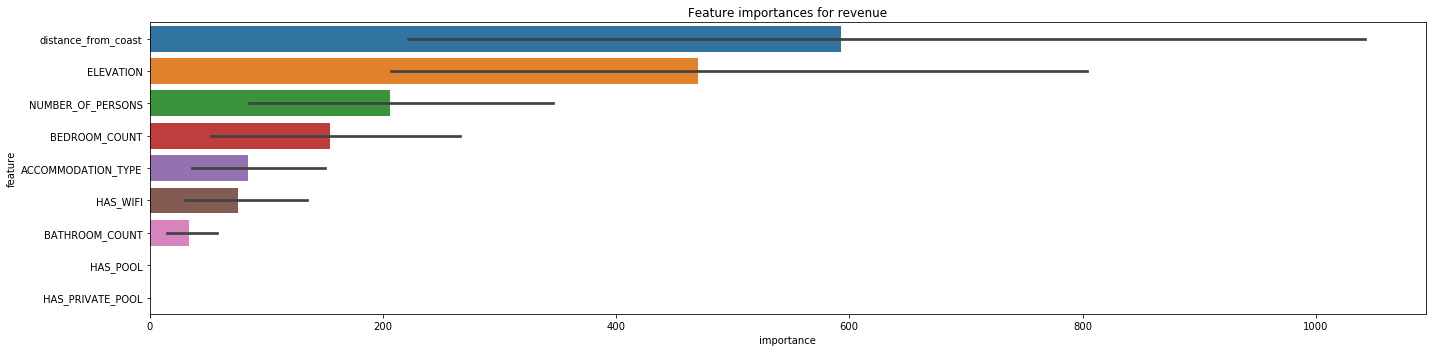

In [113]:
# Visualisation
cols = (feature_importance_df_revenue[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

best_features = feature_importance_df_revenue.loc[feature_importance_df_revenue.feature.isin(cols)]

plt.figure(figsize=(20,5))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('Feature importances for revenue')
plt.tight_layout()

In [114]:
_error = (oof_train[:] - target_revenue)

In [115]:
pred = pd.DataFrame(oof_train, columns={'predicted_revenue'})

In [116]:
print(pred.mean(), pred.median(), pred.std())

predicted_revenue    11277.476398
dtype: float64 predicted_revenue    9622.788908
dtype: float64 predicted_revenue    7186.43358
dtype: float64


In [117]:
count = 0 
for val in _error:
    if val < 3000:
        count+=1
accuracy = count/len(target_revenue)
accuracy

0.6820987654320988

In [118]:
ratio = oof_train/target_revenue

In [120]:
ratio.mean(), ratio.median(), ratio.std()

(2.0901305377360035, 1.0858956167988916, 6.429972398061003)

In [44]:
property_df[property_df["ACCOMMODATION_CODE"] == "DE-00009-71"]

,Unnamed: 0,ACCOMMODATION_CODE,ACCOMMODATION_TYPE,ACCO_DESCRIPTION,NUMBER_OF_PERSONS,BEDROOM_COUNT,BATHROOM_COUNT,HAS_WIFI,HAS_POOL,HAS_PRIVATE_POOL,HAS_SHARED_POOL,HAS_INDOOR_POOL,HAS_OUTDOOR_POOL,IS_DETACHED,HAS_SAUNA,HAS_JACUZZI,IS_SKIING,IS_ON_A_FARM,X2017.x,X2018.x,X2019.x,X2017.y,X2018.y,X2019.y,total2019,total2018,total2017,Total_HO,Total_BV,LATITUDE,LONGITUDE,max,ELEVATION,if_near_coast,distance_from_coast,nearest_coastal_longitude,nearest_coastal_latitude,COUNTRY,price,bookings_count
4948,4948,DE-00009-71,1,Apartment,4,4,1,0,0,0,0,0,0,0,0,0,0,0,0.0,236.44,59.11,573.982,6713.399,0.0,59.11,6949.839,573.982,7287.381,295.55,53.96395,11.14516,6949.839,19.0,1,23.144025,11.483356,54.025562,DE,59.11,1.0


In [45]:
property_ids["pred/gbv"] = ratio

In [46]:
property_ids["error"] = _error

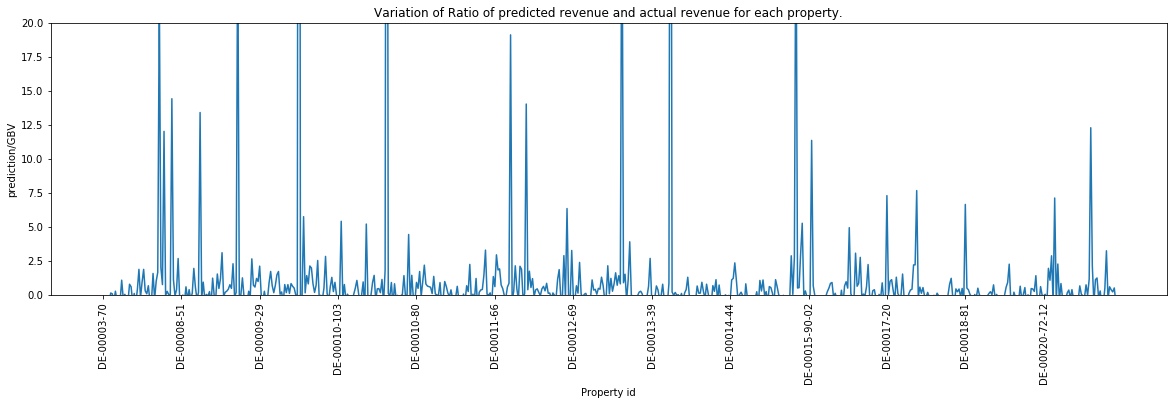

In [81]:
plt.figure(figsize=(20,5))
plt.plot(property_ids["ACCOMMODATION_CODE"], property_ids["error"])
plt.xlabel("Property id")
plt.ylabel("prediction/GBV")
plt.xticks(property_ids["ACCOMMODATION_CODE"][1::50],rotation=90)
plt.title("Variation of Ratio of predicted revenue and actual revenue for each property.")
plt.ylim(0,20)
plt.show()

In [48]:
property_ids[property_ids["error"]> 100]

,ACCOMMODATION_CODE,pred/gbv,error
4948,DE-00009-71,112.389745,111.389745


In [49]:
property_ids.quantile([0, .1, .25, .5, .75, 1], axis=0)

,pred/gbv,error
0.00,-0.192210,-1.192210
0.10,0.536030,-0.463970
0.25,0.757582,-0.242418
0.50,1.085896,0.085896
0.75,1.731169,0.731169
1.00,112.389745,111.389745


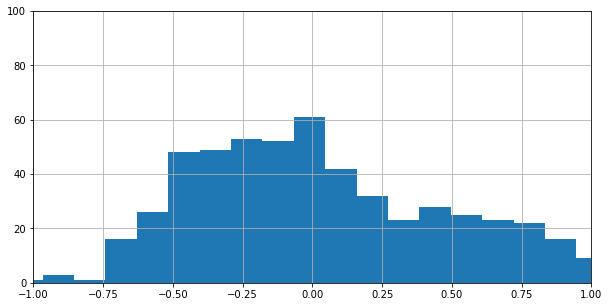

In [52]:
plt.figure(figsize=(10,5))
plt.axis([-1,1, 0, 100])
_error.hist(bins=1000)

In [ ]:
0.2*target_revenue.mean()

In [34]:
bins = np.linspace(-10, 10, 100)

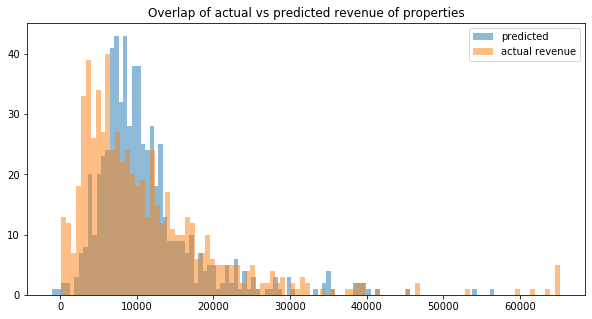

In [71]:
plt.figure(figsize=(10,5))
plt.hist(oof_train, bins=100, alpha=0.5, label='predicted')
plt.hist(target_revenue, bins=100, alpha=0.5, label='actual revenue')
plt.legend(loc='upper right')
plt.title("Overlap of actual vs predicted revenue of properties")
plt.show()